## Курсовой проект

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import catboost as catboost
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df_src = pd.read_csv('C:\course_project\course_project_train.csv')
test_df_src = pd.read_csv('C:\course_project\course_project_test.csv')
train_df_src

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0


#### Предобработка данных

Закомментил то что делало метрики ниже.

In [17]:
class DataTransform:
    def __init__(self, df):
        self.__df = None
        #на трейне и на тесте используем статистики трейна
        self.__annual_income_median = df['Annual Income'].median()
        self.__credit_score_median = df['Credit Score'].median()
        self.__total_defaults = 0 #всего дефолтов
        self.__home_ownership_cat_0 = 0 #доля дефолтов для категории домовладения 0
        self.__home_ownership_cat_1 = 0 #доля дефолтов для категории домовладения 1
        self.__home_ownership_cat_2 = 0 #доля дефолтов для категории домовладения 2
       
    
    def fit(self, df, train=True):
        self.__df = df;
        self.__transform_years_in_current_job()
        self.__transform_annual_income()
        self.__transform_credit_score()
        self.__create_home_ownership_cat()
        
        
        #на трейне и на тесте используем статистики трейна
        if train:
            self.__total_defaults = len(self.__df.loc[self.__df['Credit Default'] == 1]) 
            self.__home_ownership_cat_0 = len(self.__df.loc[(self.__df['home_ownership_cat'] == 0) & self.__df['Credit Default'] == 1])#дефолтов по категории 0
            self.__home_ownership_cat_1 = len(self.__df.loc[(self.__df['home_ownership_cat'] == 1) & self.__df['Credit Default'] == 1])#дефолтов по категории 1
            self.__home_ownership_cat_2 = len(self.__df.loc[(self.__df['home_ownership_cat'] == 2) & self.__df['Credit Default'] == 1])#дефолтов по категории 2
        
        self.__create_social_class()
        self.__create_defaults_by_home_ownership_cat()
        self.__create_credit_history_credit_score()
        self.__create_home_ownership_annual_income_median()
        self.__create_had_bankruptcies()
        self.__create_budget_burdening()
        #self.__create_annual_income_credit_score()
        #self.__create_current_credit_balalance_monthly_debt()
        #self.__create_current_loan_amount_current_credit_balance()
        #self.__create_maximum_open_credit_credit_score()
        
        self.__df['home_ownership_cat'] = self.__df['home_ownership_cat'].astype(int)
        self.__df['social_class'] = self.__df['social_class'].astype(int)
        self.__df = self.__df.drop(['Purpose'], axis=1) #половина значений числа, половина строки, непонятно что с этим делать
        
        #1200 месяцев  (100 лет) не было невозврата, то есть ни разу
        self.__df.loc[self.__df['Months since last delinquent'].isna(), 'Months since last delinquent'] = 1200
        
        return self.__df
    
    
    def __transform_years_in_current_job(self):
        self.__df.loc[self.__df['Years in current job'].isna(), 'Years in current job'] = '10+ years'#преобладает

        
    def __transform_annual_income(self):
        self.__df.loc[self.__df['Annual Income'].isna(), 'Annual Income'] = self.__annual_income_median #0 - хуже
        
        
    def __transform_credit_score(self):
        self.__df.loc[self.__df['Credit Score'].isna(), 'Credit Score'] = self.__credit_score_median #0 - хуже

        
    def __create_social_class(self):
        #доход до 200000 в год - беднота
        self.__df.loc[self.__df['Annual Income'] < 200000, 'social_class'] = 0 
        #доход от 200000 до 1500000 в год - зажиточные граждане
        self.__df.loc[(self.__df['Annual Income'] >= 200000) & (self.__df['Annual Income'] < 1500000), 'social_class'] = 1
        #доход более 1500000 в год - зажиточные граждане
        self.__df.loc[self.__df['Annual Income'] >= 1500000, 'social_class'] = 2   
                
            
    def __create_home_ownership_cat(self):
        self.__df.loc[(self.__df['Home Ownership'] == 'Home Mortgage') | (self.__df['Home Ownership'] == 'Have Mortgage'), 'home_ownership_cat'] = 0
        self.__df.loc[self.__df['Home Ownership'] == 'Rent', 'home_ownership_cat'] = 1
        self.__df.loc[self.__df['Home Ownership'] == 'Own Home', 'home_ownership_cat'] = 2      
        
        
    def __create_defaults_by_home_ownership_cat(self):
        #доля дефолтов по отношению к home_ownership_cat
        #доли дефолтов по каждой категории
        self.__df['defaults_by_home_ownership_cat'] = 0
        self.__df.loc[self.__df['home_ownership_cat'] == 0, 'defaults_by_home_ownership_cat'] = self.__total_defaults / self.__home_ownership_cat_0
        self.__df.loc[self.__df['home_ownership_cat'] == 1, 'defaults_by_home_ownership_cat'] = self.__total_defaults / self.__home_ownership_cat_1
        self.__df.loc[self.__df['home_ownership_cat'] == 2, 'defaults_by_home_ownership_cat'] = self.__total_defaults / self.__home_ownership_cat_2        
        
        
    def __create_credit_history_credit_score(self):
        self.__df['credit_history_credit_score'] = self.__df['Years of Credit History'] * self.__df['Credit Score']
        
        
    def __create_home_ownership_annual_income_median(self):    
        annual_income_median_cat_0 = self.__df.loc[self.__df['home_ownership_cat'] == 0, 'Annual Income'].median() 
        annual_income_median_cat_1 = self.__df.loc[self.__df['home_ownership_cat'] == 1, 'Annual Income'].median() 
        annual_income_median_cat_2 = self.__df.loc[self.__df['home_ownership_cat'] == 2, 'Annual Income'].median() 
        
        self.__df.loc[self.__df['home_ownership_cat'] == 0, 'home_ownership_annual_income_median'] = annual_income_median_cat_0
        self.__df.loc[self.__df['home_ownership_cat'] == 1, 'home_ownership_annual_income_median'] = annual_income_median_cat_1
        self.__df.loc[self.__df['home_ownership_cat'] == 2, 'home_ownership_annual_income_median'] = annual_income_median_cat_2
        
        
    def __create_had_bankruptcies(self):
        #были банкротства
        self.__df['had_bankruptcies'] = 0
        self.__df.loc[self.__df['Bankruptcies'] != 0, 'had_bankruptcies'] = 1
        
    
    def __create_budget_burdening(self):
        #нагрузка на бюджет
        self.__df['budget_burdening'] = self.__df['Annual Income'] / self.__df['Current Loan Amount']

        
    def __create_annual_income_credit_score(self):
        self.__df['annual_income_monthly_debt'] = self.__df['Annual Income'] / self.__df['Credit Score']
        

    def __create_current_credit_balalance_monthly_debt(self):
        self.__df['current_credit_balalance_monthly_debt'] = self.__df['Current Credit Balance'] / self.__df['Credit Score']
        
        
    def __create_current_loan_amount_current_credit_balance(self):
        self.__df['current_loan_amount_current_credit_balance'] = self.__df['Current Loan Amount'] / self.__df['Credit Score']        
        
        
    def __create_maximum_open_credit_credit_score(self):
        self.__df['maximum_open_credit_credit_score'] = self.__df['Annual Income'] / self.__df['Maximum Open Credit']         

#### Постоение кривых precision, recall, F1.

 Взято из урока 4.

In [4]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.5, 0.6, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
      
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.axhline(0.5, color="red")
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=0.5)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [5]:
dt = DataTransform(train_df_src)
train_df = dt.fit(train_df_src, True)

Удалены признаки, понижающие значение метрик.

In [6]:
target = 'Credit Default'
drop_columns = [#'Bankruptcies', 
                'Monthly Debt',
                #'Tax Liens',
                #'Current Loan Amount',
                'Annual Income',
                'Credit Score'];
X = train_df.drop(columns=target)
y = train_df[target]
X = X.drop(columns=drop_columns)
X

,Home Ownership,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,Current Loan Amount,Current Credit Balance,home_ownership_cat,social_class,defaults_by_home_ownership_cat,credit_history_credit_score,home_ownership_annual_income_median,had_bankruptcies,budget_burdening
0,Own Home,10+ years,0.0,11.0,26.3,685960.0,1.0,1200.0,1.0,Short Term,99999999.0,47386.0,2,1,11.005208,19698.7,1147448.0,1,0.004821
1,Own Home,10+ years,0.0,15.0,15.3,1181730.0,0.0,1200.0,0.0,Long Term,264968.0,394972.0,2,1,11.005208,11276.1,1147448.0,0,3.870230
2,Home Mortgage,8 years,0.0,11.0,35.0,1182434.0,0.0,1200.0,0.0,Short Term,99999999.0,308389.0,0,1,2.301743,25970.0,1168386.0,0,0.007514
3,Own Home,6 years,0.0,8.0,22.5,147400.0,1.0,1200.0,1.0,Short Term,121396.0,95855.0,2,1,11.005208,15615.0,1147448.0,1,6.631751
4,Rent,8 years,0.0,13.0,13.6,385836.0,1.0,1200.0,0.0,Short Term,125840.0,93309.0,1,1,2.106680,9778.4,1168386.0,0,6.168659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,< 1 year,0.0,3.0,8.5,107866.0,0.0,1200.0,0.0,Short Term,129360.0,73492.0,1,1,2.106680,5924.5,1168386.0,0,3.109091
7496,Home Mortgage,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,Long Term,444048.0,456399.0,0,2,2.301743,196365.0,1168386.0,0,3.454545
7497,Rent,6 years,0.0,12.0,32.1,1778920.0,0.0,1200.0,0.0,Short Term,99999999.0,477812.0,1,2,2.106680,24010.8,1168386.0,0,0.018789
7498,Home Mortgage,10+ years,0.0,21.0,26.5,1141250.0,0.0,1200.0,0.0,Short Term,615274.0,476064.0,0,1,2.301743,19371.5,1168386.0,0,1.898969


#### Подбор макропараметров для модели.

In [7]:
%%time
cat_features=['Home Ownership', 
              'Years in current job', 
              'home_ownership_cat', 
              'social_class',
              'had_bankruptcies',
              'Term']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=22)
scale = y_train[y_train == 0].shape[0] / y_train[y_train == 1].shape[0]

catb_gscv = catboost.CatBoostClassifier(cat_features=cat_features)
params = {'depth': [4,5],
          #'loss_function': ['Logloss', 'CrossEntropy'],
          'l2_leaf_reg': [0.03, 0.04, 0.05],
          'n_estimators': [180, 190],
          'auto_class_weights': ['Balanced'], 
          'learning_rate': [0.04, 0.05],
          #'leaf_estimation_iterations': [10],
#           'eval_metric': ['Accuracy'],
#           'use_best_model': ['True'],
          #'scale_pos_weight': [scale],
          'logging_level':['Silent'],
          'random_state': [22]
         }
gscv = GridSearchCV(estimator=catb_gscv, param_grid=params, cv=5)
grid_result = gscv.fit(X_train, y_train)
best_params = grid_result.best_params_
best_params

Wall time: 5min 27s


{'auto_class_weights': 'Balanced',
 'depth': 5,
 'l2_leaf_reg': 0.04,
 'learning_rate': 0.04,
 'logging_level': 'Silent',
 'n_estimators': 180,
 'random_state': 22}

#### В модель передаются best_params_

In [8]:
%%time
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=22)
catb = catboost.CatBoostClassifier(max_depth=best_params['depth'],
                                   #loss_function=best_params['loss_function'],
                                   l2_leaf_reg=best_params['l2_leaf_reg'],
                                   learning_rate=best_params['learning_rate'],
                                   n_estimators=best_params['n_estimators'], 
                                   auto_class_weights='Balanced', 
                                   #scale_pos_weight=scale,
                                   silent=True, 
                                   random_state=22)
catb.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_valid, y_valid))

Wall time: 2.86 s


#### По трём метрикам разница между обучающей и контрольной выборками не более 2% - переобучения нет.

In [9]:
y_train_pred = catb.predict(X_train)
y_valid_pred = catb.predict(X_valid)
print('precision, recall и f1-score для обучающей выборки\n\n' + classification_report(y_train, y_train_pred))
print('precision, recall и f1-score для контрольной выборки\n\n' + classification_report(y_valid, y_valid_pred))

precision, recall и f1-score для обучающей выборки

              precision    recall  f1-score   support

           0       0.85      0.75      0.80      3620
           1       0.51      0.66      0.58      1405

    accuracy                           0.73      5025
   macro avg       0.68      0.71      0.69      5025
weighted avg       0.76      0.73      0.74      5025

precision, recall и f1-score для контрольной выборки

              precision    recall  f1-score   support

           0       0.84      0.75      0.79      1767
           1       0.51      0.64      0.56       708

    accuracy                           0.72      2475
   macro avg       0.67      0.69      0.68      2475
weighted avg       0.74      0.72      0.73      2475



#### Зависимость метрик от прога вероятности, требуется скорректировать для улучшения показателей.

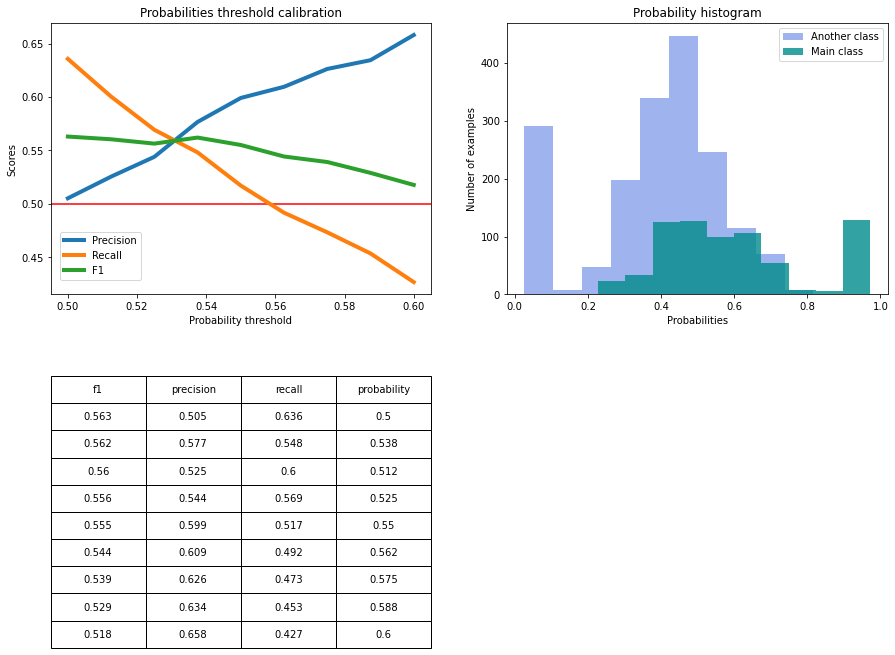

In [10]:
y_valid_pred_probs = catb.predict_proba(X_valid)[:, 1]
show_proba_calibration_plots(y_valid_pred_probs, y_valid)

#### Оптимальный порог - 0.533, метрики для класса 1 не ниже 0.56.

In [19]:
y_valid_proba_corrected = np.where(y_valid_pred_probs > 0.533, 1, 0)
print('precision, recall и f1-score для контрольной выборки\n\n' + classification_report(y_valid, y_valid_proba_corrected))

precision, recall и f1-score для контрольной выборки

              precision    recall  f1-score   support

           0       0.82      0.83      0.83      1767
           1       0.57      0.56      0.56       708

    accuracy                           0.75      2475
   macro avg       0.70      0.69      0.69      2475
weighted avg       0.75      0.75      0.75      2475



#### Обработка тестовых данных и сохранение в файл

Для сдачи выбран порог 0.533, однако, на kaggle лучше работает 0.44 score=0.62236 (rigor mortis)

In [21]:
test_df = dt.fit(test_df_src, False)
test_df = test_df.drop(columns=drop_columns)
y_test_pred = catb.predict(test_df)

y_test_pred_probs = catb.predict_proba(test_df)[:, 1]
y_test_proba_corrected = np.where(y_test_pred_probs > 0.533, 1, 0)
y_test_proba_corrected
pd.DataFrame(y_test_proba_corrected).to_csv('c:\\test\\submision.csv', header=None, index=None)